<a href="https://colab.research.google.com/github/LeeYuuuan/ECGR-5106-HW2/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models



transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


trainset100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader100 = torch.utils.data.DataLoader(trainset100, batch_size=128, shuffle=True, num_workers=2)
testset100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader100 = torch.utils.data.DataLoader(testset100, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 169M/169M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import torch.nn as nn

class MyAlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout=True):
        super(MyAlexNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x


In [26]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, trainloader, testloader, epochs=50, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss/len(trainloader))

        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss/len(testloader))
        val_accs.append(correct/total)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(trainloader)}, Val Loss = {val_loss/len(testloader)}, Val Acc = {correct/total:.4f}")

    return train_losses, val_losses, val_accs

def plot_losses_accs(train_losses, val_losses, val_accs, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.title(title+' '+'loss')
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title(title+' '+'accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




In [34]:
from matplotlib import pyplot as plt
def compare_two_models(train_loss_1, val_loss_1, val_acc_1, train_loss_2, val_loss_2, val_acc_2, title, model_name_1, model_name_2):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.title(title+' '+'loss')
    plt.plot(train_loss_1, label=f'Training Loss {model_name_1}')
    plt.plot(val_loss_1, label=f'Validation Loss {model_name_1}')
    plt.plot(train_loss_2, label=f'Training Loss {model_name_2}')
    plt.plot(val_loss_2, label=f'Validation Loss {model_name_2}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title(title+' '+'accuracy')

    plt.plot(val_acc_1, label=f'Validation Accuracy {model_name_1}')
    plt.plot(val_acc_2, label=f'Validation Accuracy {model_name_2}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



## CIFAR10

Epoch 1: Train Loss = 1.8744982825520704, Val Loss = 1.5326923298835755, Val Acc = 0.4323
Epoch 2: Train Loss = 1.4566401440621641, Val Loss = 1.3128597688674928, Val Acc = 0.5244
Epoch 3: Train Loss = 1.2698016768831122, Val Loss = 1.1740341758728028, Val Acc = 0.5692
Epoch 4: Train Loss = 1.142978872941888, Val Loss = 1.0615314489603043, Val Acc = 0.6277
Epoch 5: Train Loss = 1.0498940488109199, Val Loss = 0.9843558073043823, Val Acc = 0.6451
Epoch 6: Train Loss = 0.972744573031545, Val Loss = 0.9491499596834183, Val Acc = 0.6707
Epoch 7: Train Loss = 0.9117966106785532, Val Loss = 0.8904944616556167, Val Acc = 0.6924
Epoch 8: Train Loss = 0.8719091851006994, Val Loss = 0.8665722888708115, Val Acc = 0.7019
Epoch 9: Train Loss = 0.8367659069616776, Val Loss = 0.857264574766159, Val Acc = 0.7016
Epoch 10: Train Loss = 0.7928185792606505, Val Loss = 0.8649507623910904, Val Acc = 0.6976
Epoch 11: Train Loss = 0.766879639624025, Val Loss = 0.7795506572723389, Val Acc = 0.7347
Epoch 12: Tr

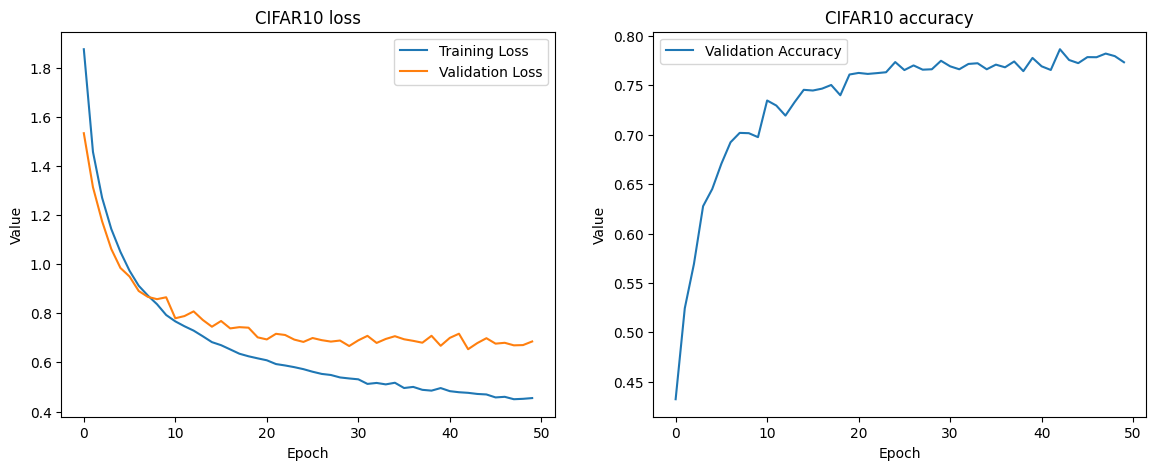

In [28]:
model_cifar10 = MyAlexNet(num_classes=10, dropout=True)
train_losses_cifar10, val_losses_cifar10, val_accs_cifar10 = train_model(model_cifar10, trainloader, testloader)
plot_losses_accs(train_losses_cifar10, val_losses_cifar10, val_accs_cifar10, "CIFAR10")

Epoch 1: Train Loss = 1.7773033141175194, Val Loss = 1.5714678514003753, Val Acc = 0.4337
Epoch 2: Train Loss = 1.3585277567891514, Val Loss = 1.332457605600357, Val Acc = 0.5119
Epoch 3: Train Loss = 1.1650788381581416, Val Loss = 1.07940012216568, Val Acc = 0.6182
Epoch 4: Train Loss = 1.040163322559098, Val Loss = 1.0036779421567916, Val Acc = 0.6406
Epoch 5: Train Loss = 0.9395214865732071, Val Loss = 0.9711146140098572, Val Acc = 0.6553
Epoch 6: Train Loss = 0.8588646298555462, Val Loss = 0.960024065375328, Val Acc = 0.6661
Epoch 7: Train Loss = 0.7969695173032448, Val Loss = 0.8813548547029495, Val Acc = 0.6943
Epoch 8: Train Loss = 0.7482517977123675, Val Loss = 0.8672504937648773, Val Acc = 0.7069
Epoch 9: Train Loss = 0.6983224978989653, Val Loss = 0.8341596513986588, Val Acc = 0.7168
Epoch 10: Train Loss = 0.6621744021049241, Val Loss = 0.7425318902730942, Val Acc = 0.7424
Epoch 11: Train Loss = 0.6286406532654067, Val Loss = 0.7757312327623367, Val Acc = 0.7357
Epoch 12: Tra

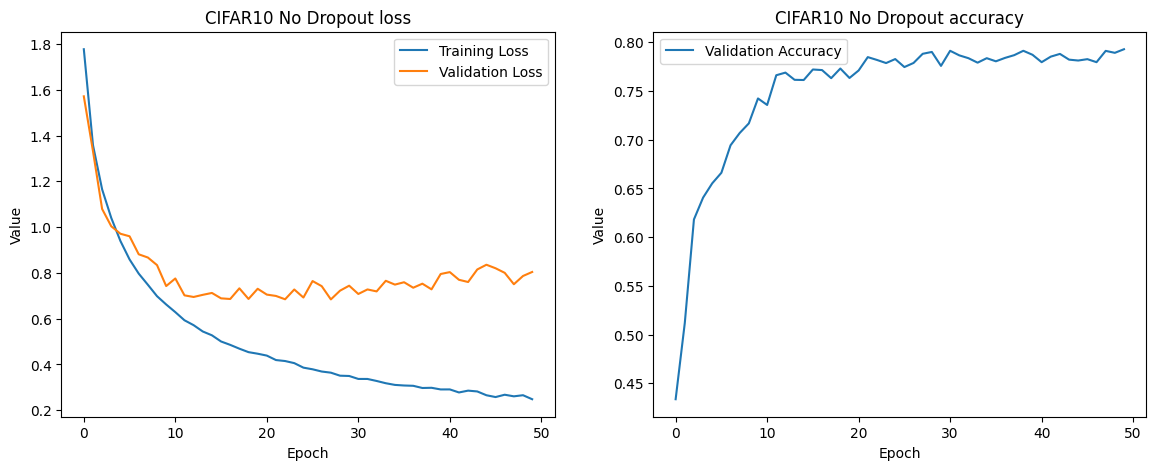

In [30]:
model_cifar10_no_dropout = MyAlexNet(num_classes=10, dropout=False)
train_losses_cifar10_no_dropout, val_losses_cifar10_no_dropout, val_accs_cifar10_no_dropout = train_model(model_cifar10_no_dropout, trainloader, testloader)
plot_losses_accs(train_losses_cifar10_no_dropout, val_losses_cifar10_no_dropout, val_accs_cifar10_no_dropout, "CIFAR10 No Dropout")

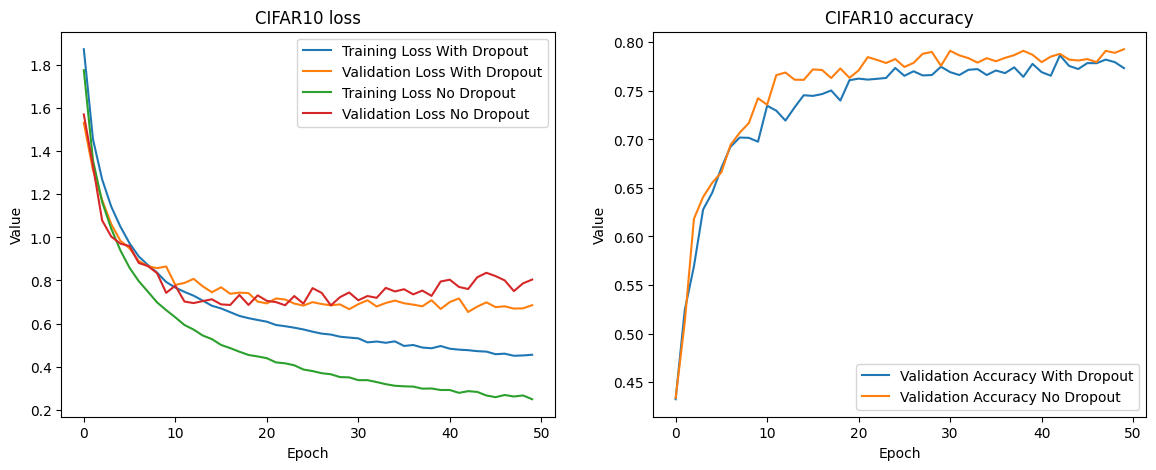

In [35]:
compare_two_models(train_losses_cifar10, val_losses_cifar10, val_accs_cifar10, train_losses_cifar10_no_dropout, val_losses_cifar10_no_dropout, val_accs_cifar10_no_dropout, "CIFAR10", "With Dropout", "No Dropout")

## CIFAR100

Epoch 1: Train Loss = 4.3065878393704935, Val Loss = 4.042422454357148, Val Acc = 0.0589
Epoch 2: Train Loss = 3.9537245019927356, Val Loss = 3.767601583003998, Val Acc = 0.1080
Epoch 3: Train Loss = 3.735182523727417, Val Loss = 3.5256090807914733, Val Acc = 0.1528
Epoch 4: Train Loss = 3.5586511076563765, Val Loss = 3.313499162197113, Val Acc = 0.1886
Epoch 5: Train Loss = 3.4140801557799434, Val Loss = 3.3056258583068847, Val Acc = 0.2002
Epoch 6: Train Loss = 3.309587962792048, Val Loss = 3.112091534137726, Val Acc = 0.2355
Epoch 7: Train Loss = 3.203267712117461, Val Loss = 3.0499134135246275, Val Acc = 0.2447
Epoch 8: Train Loss = 3.1158441149670146, Val Loss = 2.9696886467933656, Val Acc = 0.2617
Epoch 9: Train Loss = 3.043762418010351, Val Loss = 2.886837589740753, Val Acc = 0.2828
Epoch 10: Train Loss = 2.9677445784859033, Val Loss = 2.8553121757507323, Val Acc = 0.2917
Epoch 11: Train Loss = 2.906303144781791, Val Loss = 2.8002859592437743, Val Acc = 0.2995
Epoch 12: Train Lo

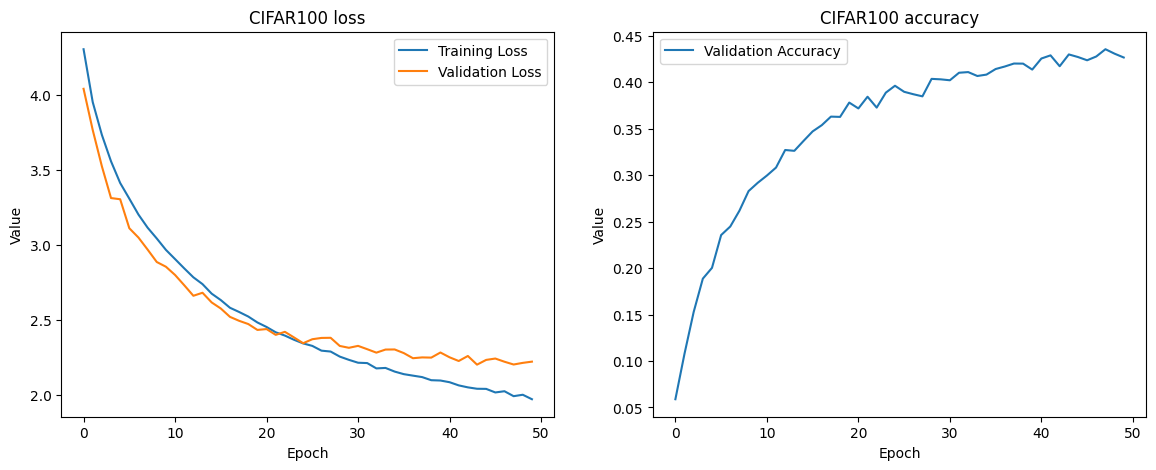

In [68]:
model_cifar100 = MyAlexNet(num_classes=100, dropout=True)
train_losses_cifar100, val_losses_cifar100, val_accs_cifar100 = train_model(model_cifar100, trainloader100, testloader100)
plot_losses_accs(train_losses_cifar100, val_losses_cifar100, val_accs_cifar100, "CIFAR100")

Epoch 1: Train Loss = 4.177490400841169, Val Loss = 3.8917840671539308, Val Acc = 0.0806
Epoch 2: Train Loss = 3.683767214455568, Val Loss = 3.5222665333747862, Val Acc = 0.1517
Epoch 3: Train Loss = 3.3712809402924364, Val Loss = 3.2334606981277467, Val Acc = 0.2067
Epoch 4: Train Loss = 3.1149074641030157, Val Loss = 3.0564032769203187, Val Acc = 0.2497
Epoch 5: Train Loss = 2.907102574472842, Val Loss = 2.9235276222229003, Val Acc = 0.2792
Epoch 6: Train Loss = 2.7475738061968324, Val Loss = 2.7702747488021853, Val Acc = 0.2995
Epoch 7: Train Loss = 2.60522582159018, Val Loss = 2.703603730201721, Val Acc = 0.3148
Epoch 8: Train Loss = 2.480473370808165, Val Loss = 2.6044426584243774, Val Acc = 0.3370
Epoch 9: Train Loss = 2.3703325233800943, Val Loss = 2.5354139614105224, Val Acc = 0.3532
Epoch 10: Train Loss = 2.2576014541299143, Val Loss = 2.503247249126434, Val Acc = 0.3619
Epoch 11: Train Loss = 2.177110339064732, Val Loss = 2.4324491810798645, Val Acc = 0.3806
Epoch 12: Train L

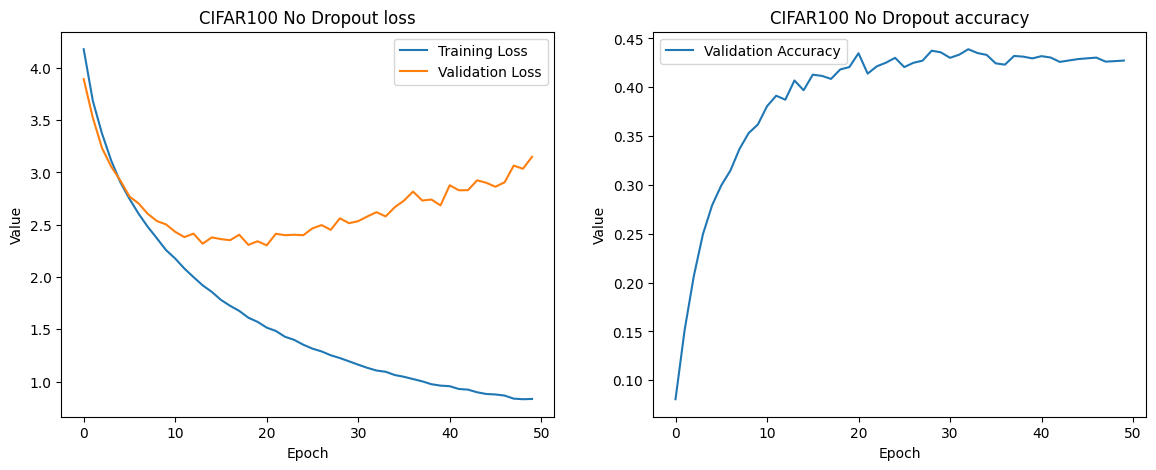

In [69]:
model_cifar100_no_dropout = MyAlexNet(num_classes=100, dropout=False)
train_losses_cifar100_no_dropout, val_losses_cifar100_no_dropout, val_accs_cifar100_no_dropout = train_model(model_cifar100_no_dropout, trainloader100, testloader100)
plot_losses_accs(train_losses_cifar100_no_dropout, val_losses_cifar100_no_dropout, val_accs_cifar100_no_dropout, "CIFAR100 No Dropout")


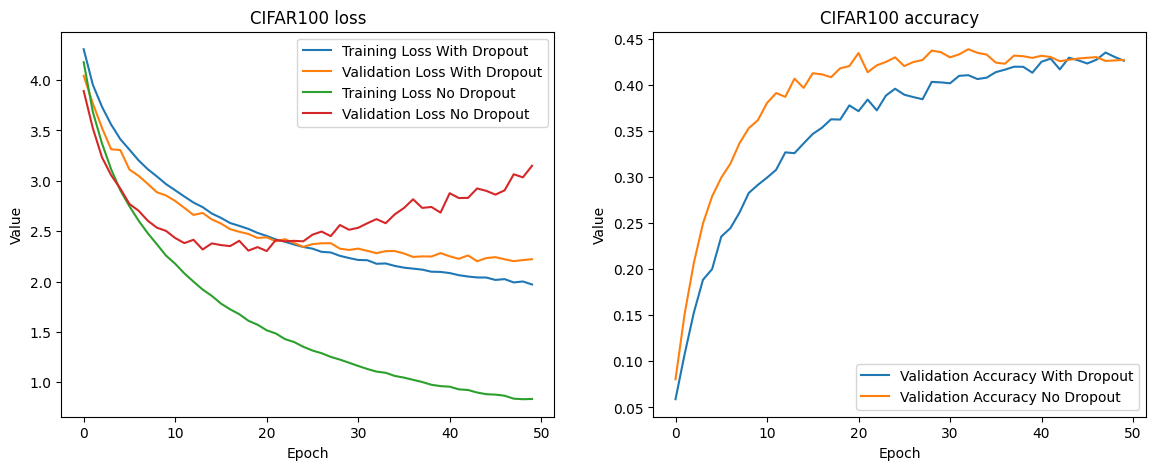

In [70]:
compare_two_models(train_losses_cifar100, val_losses_cifar100, val_accs_cifar100, train_losses_cifar100_no_dropout, val_losses_cifar100_no_dropout, val_accs_cifar100_no_dropout, "CIFAR100", "With Dropout", "No Dropout")


In [40]:
import torchsummary
torchsummary.summary(model_cifar10, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
           Linear-14                  [

# Problem 2

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Definition of network model class
class VGG11(nn.Module):
    def __init__(self, num_classes=10, dropout=True):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 256),
            nn.ReLU(),
            nn.Dropout() if dropout else nn.Identity(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout() if dropout else nn.Identity(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

## CIFAR10

Epoch 1: Train Loss = 1.7524381703622662, Val Loss = 1.4363805619291603, Val Acc = 0.4645
Epoch 2: Train Loss = 1.3107964570371295, Val Loss = 1.1201409223361518, Val Acc = 0.6034
Epoch 3: Train Loss = 1.076516890975808, Val Loss = 1.014707506369478, Val Acc = 0.6438
Epoch 4: Train Loss = 0.9433744667778393, Val Loss = 0.9035653616673649, Val Acc = 0.6921
Epoch 5: Train Loss = 0.8400757942379703, Val Loss = 0.9027589938511102, Val Acc = 0.6934
Epoch 6: Train Loss = 0.7709346441546084, Val Loss = 0.9046307088087161, Val Acc = 0.7001
Epoch 7: Train Loss = 0.7030648201970968, Val Loss = 0.8764106931206518, Val Acc = 0.7098
Epoch 8: Train Loss = 0.652407942810504, Val Loss = 0.879174932028158, Val Acc = 0.7120
Epoch 9: Train Loss = 0.6006907425148702, Val Loss = 0.8169619649553451, Val Acc = 0.7344
Epoch 10: Train Loss = 0.5692016999556022, Val Loss = 0.8783491302412539, Val Acc = 0.7258
Epoch 11: Train Loss = 0.5334381807788549, Val Loss = 0.8821117534709815, Val Acc = 0.7306
Epoch 12: Tr

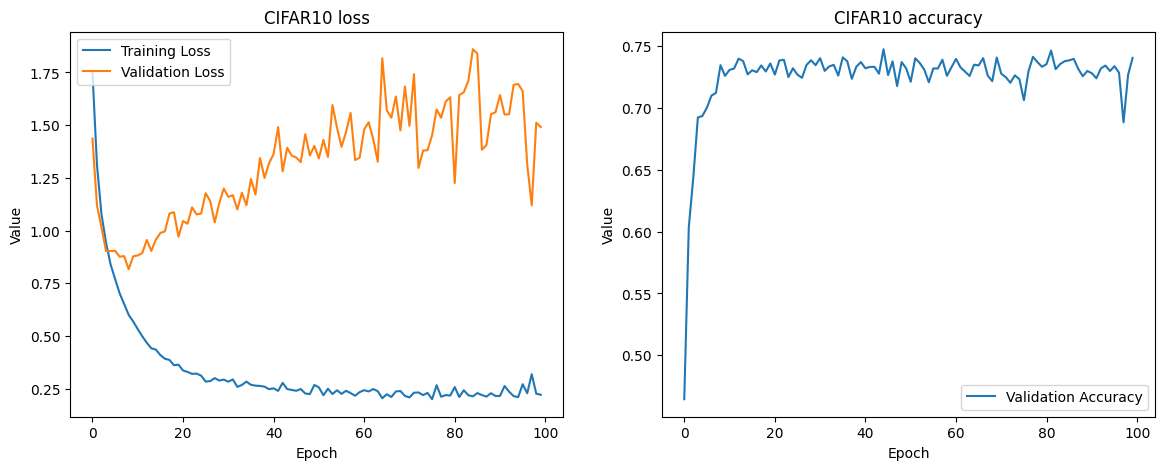

In [71]:
vgg11_cifar10 = VGG11(num_classes=10)
train_losses_vgg11_cifar10, val_losses_vgg11_cifar10, val_accs_vgg11_cifar10 = train_model(vgg11_cifar10, trainloader, testloader, epochs=100)
plot_losses_accs(train_losses_vgg11_cifar10, val_losses_vgg11_cifar10, val_accs_vgg11_cifar10, "CIFAR10")

Epoch 1: Train Loss = 1.7047669746825425, Val Loss = 1.3815604334060376, Val Acc = 0.4916
Epoch 2: Train Loss = 1.2001332570479912, Val Loss = 1.0632782582276927, Val Acc = 0.6242
Epoch 3: Train Loss = 0.9636884237128958, Val Loss = 0.9323931618239552, Val Acc = 0.6751
Epoch 4: Train Loss = 0.8099508518335229, Val Loss = 0.8865579085799452, Val Acc = 0.6870
Epoch 5: Train Loss = 0.703870479715839, Val Loss = 0.8284996998386261, Val Acc = 0.7153
Epoch 6: Train Loss = 0.6104727146988562, Val Loss = 0.8558599430912981, Val Acc = 0.7129
Epoch 7: Train Loss = 0.5279418192923031, Val Loss = 0.794434745614521, Val Acc = 0.7400
Epoch 8: Train Loss = 0.45872210939096014, Val Loss = 0.845245988129046, Val Acc = 0.7371
Epoch 9: Train Loss = 0.39680790834924917, Val Loss = 0.9007208067388199, Val Acc = 0.7327
Epoch 10: Train Loss = 0.3518651258832014, Val Loss = 0.9250781902680382, Val Acc = 0.7405
Epoch 11: Train Loss = 0.3049407799383214, Val Loss = 1.151687844587972, Val Acc = 0.7219
Epoch 12: 

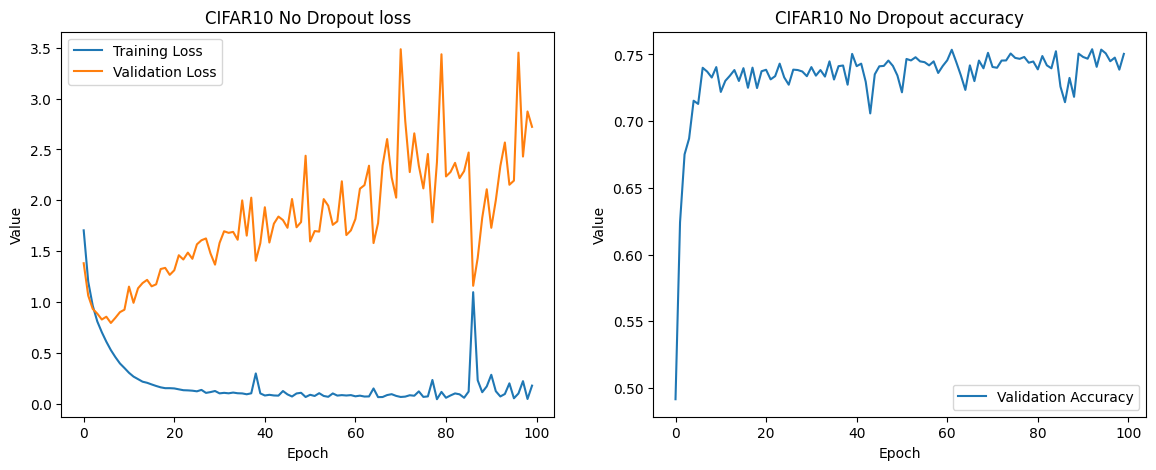

In [72]:
vgg11_cifar10_no_dropout = VGG11(num_classes=10, dropout=False)
train_losses_vgg11_cifar10_no_dropout, val_losses_vgg11_cifar10_no_dropout, val_accs_vgg11_cifar10_no_dropout = train_model(vgg11_cifar10_no_dropout, trainloader, testloader, epochs=100)
plot_losses_accs(train_losses_vgg11_cifar10_no_dropout, val_losses_vgg11_cifar10_no_dropout, val_accs_vgg11_cifar10_no_dropout, "CIFAR10 No Dropout")

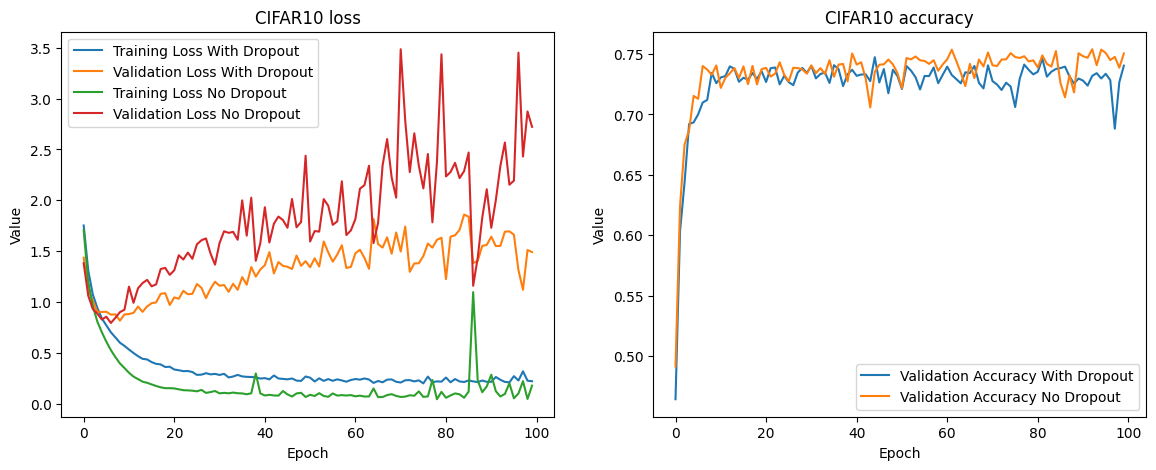

In [73]:
compare_two_models(train_losses_vgg11_cifar10, val_losses_vgg11_cifar10, val_accs_vgg11_cifar10, train_losses_vgg11_cifar10_no_dropout, val_losses_vgg11_cifar10_no_dropout, val_accs_vgg11_cifar10_no_dropout, "CIFAR10", "With Dropout", "No Dropout")

## CIFAR100

Epoch 1: Train Loss = 4.489586122810383, Val Loss = 4.25319399356842, Val Acc = 0.0373
Epoch 2: Train Loss = 4.13131592889576, Val Loss = 3.971069300174713, Val Acc = 0.0610
Epoch 3: Train Loss = 3.973381277240451, Val Loss = 3.83384756565094, Val Acc = 0.0949
Epoch 4: Train Loss = 3.864687494609667, Val Loss = 3.765174751281738, Val Acc = 0.1061
Epoch 5: Train Loss = 3.7686706217353607, Val Loss = 3.671204273700714, Val Acc = 0.1210
Epoch 6: Train Loss = 3.668541621064286, Val Loss = 3.547752194404602, Val Acc = 0.1463
Epoch 7: Train Loss = 3.5906874096911885, Val Loss = 3.43071409702301, Val Acc = 0.1595
Epoch 8: Train Loss = 3.4998453657340516, Val Loss = 3.3888441514968872, Val Acc = 0.1751
Epoch 9: Train Loss = 3.431598917602578, Val Loss = 3.302841682434082, Val Acc = 0.1938
Epoch 10: Train Loss = 3.358785732932713, Val Loss = 3.229128746986389, Val Acc = 0.2064
Epoch 11: Train Loss = 3.3048040750996233, Val Loss = 3.1941069388389587, Val Acc = 0.2167
Epoch 12: Train Loss = 3.244

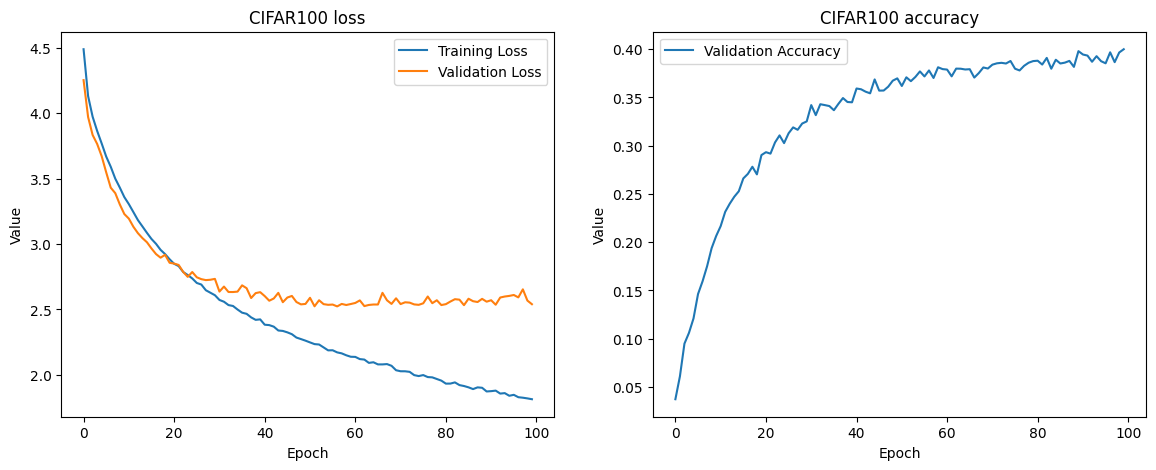

In [98]:
vgg11_cifar100 = VGG11(num_classes=100)
train_losses_vgg11_cifar100, val_losses_vgg11_cifar100, val_accs_vgg11_cifar100 = train_model(vgg11_cifar100, trainloader100, testloader100, epochs=100)
plot_losses_accs(train_losses_vgg11_cifar100, val_losses_vgg11_cifar100, val_accs_vgg11_cifar100, "CIFAR100")

Epoch 1: Train Loss = 4.352002087761374, Val Loss = 4.142542464733124, Val Acc = 0.0350
Epoch 2: Train Loss = 4.001897982014414, Val Loss = 3.8798535013198854, Val Acc = 0.0851
Epoch 3: Train Loss = 3.7575146279981375, Val Loss = 3.6316596245765687, Val Acc = 0.1256
Epoch 4: Train Loss = 3.5422649103052475, Val Loss = 3.4259285593032835, Val Acc = 0.1609
Epoch 5: Train Loss = 3.3458215330567813, Val Loss = 3.2700159478187563, Val Acc = 0.1916
Epoch 6: Train Loss = 3.17770784651227, Val Loss = 3.123597626686096, Val Acc = 0.2238
Epoch 7: Train Loss = 3.0288836413332265, Val Loss = 3.0326624870300294, Val Acc = 0.2455
Epoch 8: Train Loss = 2.893150249710473, Val Loss = 2.8832730531692503, Val Acc = 0.2696
Epoch 9: Train Loss = 2.7803472856731366, Val Loss = 2.880848345756531, Val Acc = 0.2792
Epoch 10: Train Loss = 2.6687148385645485, Val Loss = 2.74832923412323, Val Acc = 0.3002
Epoch 11: Train Loss = 2.5784097138573143, Val Loss = 2.6745999908447264, Val Acc = 0.3201
Epoch 12: Train Lo

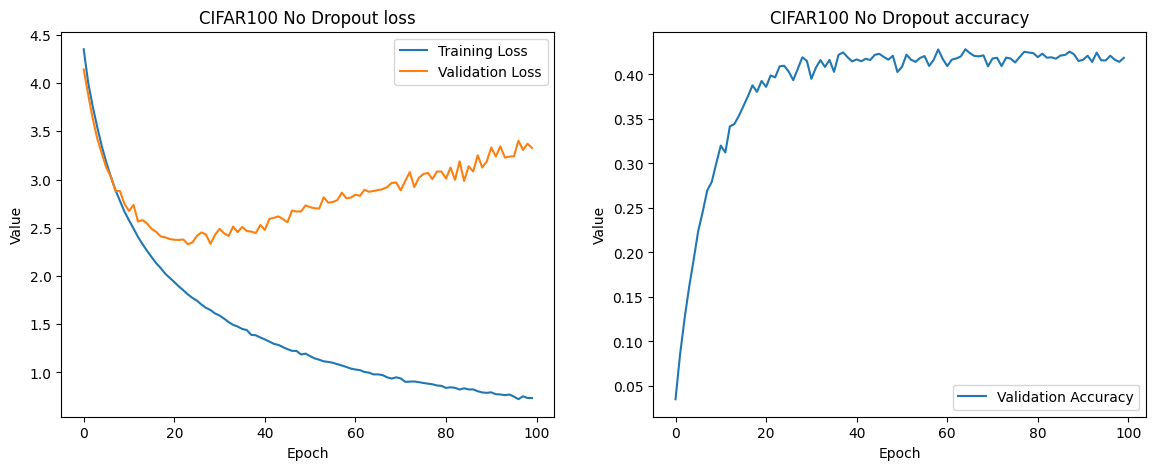

In [75]:
vgg11_cifar100_no_dropout = VGG11(num_classes=100, dropout=False)
train_losses_vgg11_cifar100_no_dropout, val_losses_vgg11_cifar100_no_dropout, val_accs_vgg11_cifar100_no_dropout = train_model(vgg11_cifar100_no_dropout, trainloader100, testloader100, epochs=100)
plot_losses_accs(train_losses_vgg11_cifar100_no_dropout, val_losses_vgg11_cifar100_no_dropout, val_accs_vgg11_cifar100_no_dropout, "CIFAR100 No Dropout")

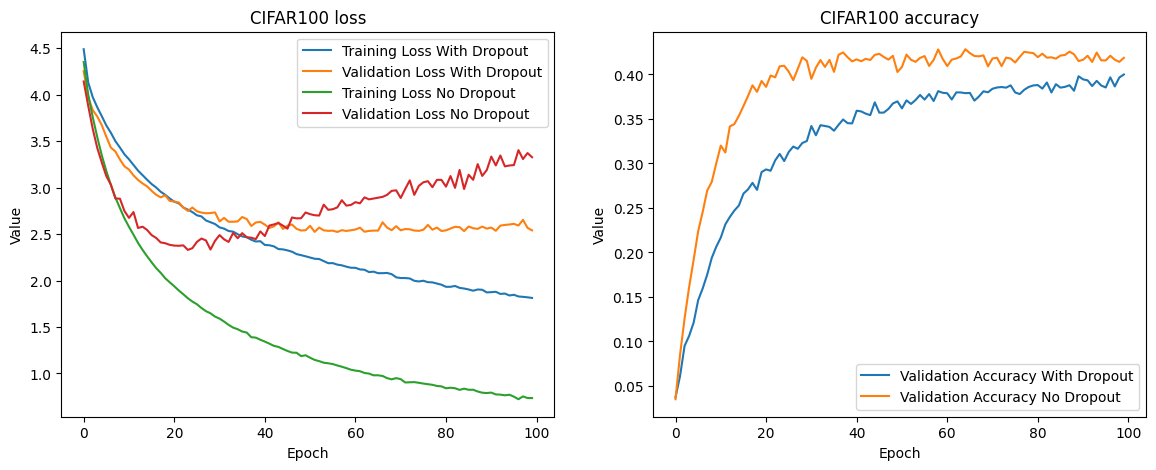

In [99]:
compare_two_models(train_losses_vgg11_cifar100, val_losses_vgg11_cifar100, val_accs_vgg11_cifar100, train_losses_vgg11_cifar100_no_dropout, val_losses_vgg11_cifar100_no_dropout, val_accs_vgg11_cifar100_no_dropout, "CIFAR100", "With Dropout", "No Dropout")

In [66]:
torchsummary.summary(vgg11_cifar10, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
        MaxPool2d-14            [-1, 51

## Problem 3

## resnet 11

In [80]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional module for activation functions and more
import torch.optim as optim
import matplotlib.pyplot as plt

class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Forward pass through the first convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through the second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Adding the shortcut connection's output to the main path's output
        out += self.shortcut(x)
        # Final ReLU activation after adding the shortcut
        out = F.relu(out)
        return out

class ResNet11(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout=True):
        super(ResNet11, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Final fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(512 * block.expansion, 256),
            nn.ReLU(),
            nn.Dropout() if dropout else nn.Identity(),
            nn.Linear(256, num_classes)
        )
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)  # Forward pass through the final fully connected layer
        return out

#ResNet11:have 11 layers in total, including convolutional and fully connected layers.
#it could have 4 residual blocks with a varying number of convolutional layers in each block to make up a total of 11 layers.

# Example of using the ResNet11 model





Epoch 1: Train Loss = 1.272476574319033, Val Loss = 1.0652027710938987, Val Acc = 0.6198
Epoch 2: Train Loss = 0.7871259593631851, Val Loss = 0.7002764086182506, Val Acc = 0.7587
Epoch 3: Train Loss = 0.5853155466727317, Val Loss = 0.598446560077393, Val Acc = 0.7959
Epoch 4: Train Loss = 0.439636966188558, Val Loss = 0.564815168896803, Val Acc = 0.8087
Epoch 5: Train Loss = 0.3194400384540712, Val Loss = 0.5543010403363469, Val Acc = 0.8142
Epoch 6: Train Loss = 0.22103551393154333, Val Loss = 0.5923188674849824, Val Acc = 0.8227
Epoch 7: Train Loss = 0.1429062783438057, Val Loss = 0.6224901110600358, Val Acc = 0.8229
Epoch 8: Train Loss = 0.10567619772604116, Val Loss = 0.7425793754502227, Val Acc = 0.8113
Epoch 9: Train Loss = 0.08343820993521, Val Loss = 0.7396276821486485, Val Acc = 0.8175
Epoch 10: Train Loss = 0.07058141435411898, Val Loss = 0.7934118009175355, Val Acc = 0.8180
Epoch 11: Train Loss = 0.06529416132211699, Val Loss = 0.772722164472452, Val Acc = 0.8257
Epoch 12: T

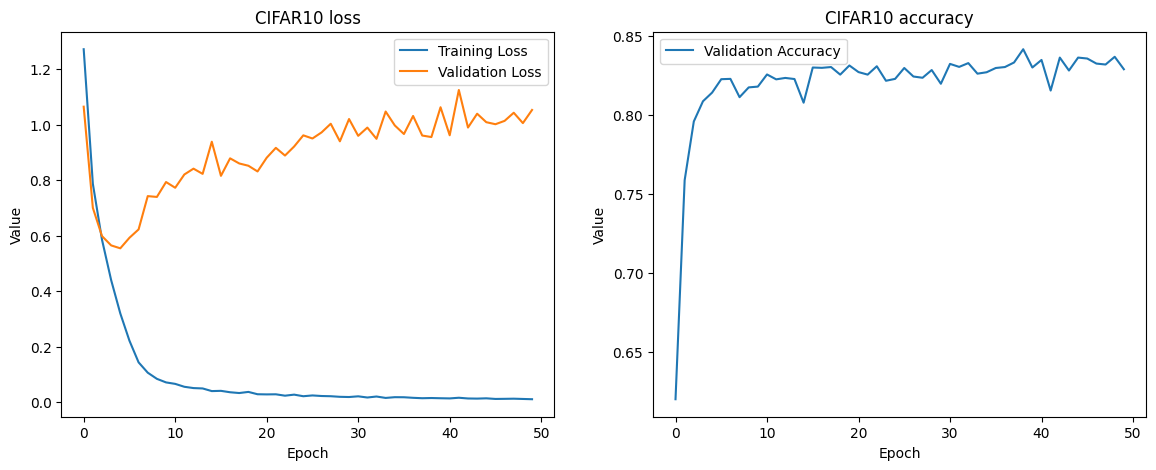

In [78]:
resnet11_cifar10 = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=10)  # 4 blocks with 1 layer each
train_losses_resnet11_cifar10, val_losses_resnet11_cifar10, val_accs_resnet11_cifar10 = train_model(resnet11_cifar10, trainloader, testloader, epochs=50)
plot_losses_accs(train_losses_resnet11_cifar10, val_losses_resnet11_cifar10, val_accs_resnet11_cifar10, "CIFAR10")

Epoch 1: Train Loss = 1.313723529941061, Val Loss = 1.0458936413256124, Val Acc = 0.6253
Epoch 2: Train Loss = 0.851631249476913, Val Loss = 0.7567298025749742, Val Acc = 0.7337
Epoch 3: Train Loss = 0.6375172420220732, Val Loss = 0.6335591456284538, Val Acc = 0.7836
Epoch 4: Train Loss = 0.4933525169660324, Val Loss = 0.5832907488456549, Val Acc = 0.8056
Epoch 5: Train Loss = 0.37131601203797876, Val Loss = 0.5923382130008155, Val Acc = 0.8106
Epoch 6: Train Loss = 0.27444261363251654, Val Loss = 0.584675907993469, Val Acc = 0.8186
Epoch 7: Train Loss = 0.18992267827242995, Val Loss = 0.6324416808664989, Val Acc = 0.8137
Epoch 8: Train Loss = 0.13703081956397212, Val Loss = 0.6494635326888996, Val Acc = 0.8225
Epoch 9: Train Loss = 0.10592822169736671, Val Loss = 0.7219465776754264, Val Acc = 0.8188
Epoch 10: Train Loss = 0.08883381682269034, Val Loss = 0.712970682416861, Val Acc = 0.8244
Epoch 11: Train Loss = 0.0777397711058335, Val Loss = 0.8291542326120999, Val Acc = 0.8168
Epoch 

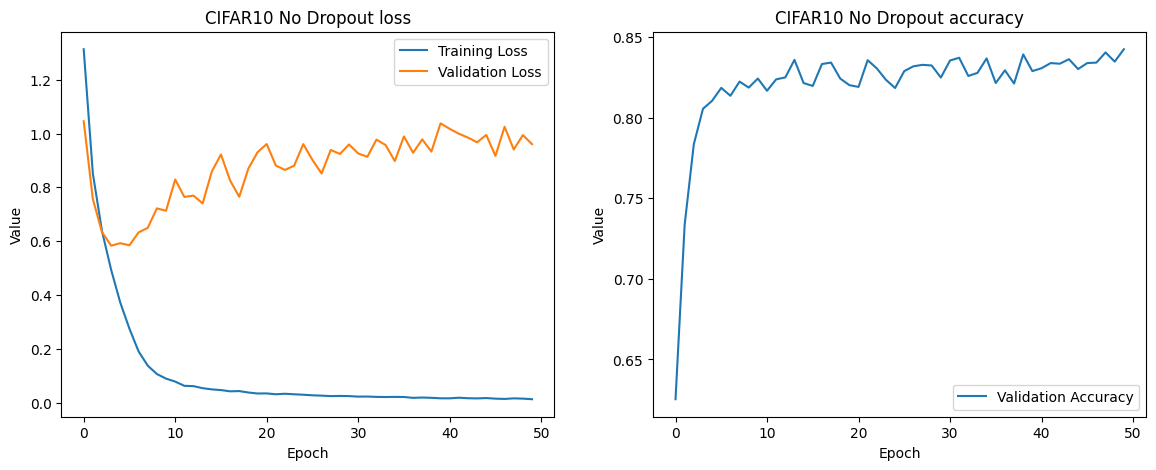

In [81]:
resnet11_cifar10_no_dropout = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=10, dropout=False)
train_losses_resnet11_cifar10_no_dropout, val_losses_resnet11_cifar10_no_dropout, val_accs_resnet11_cifar10_no_dropout = train_model(resnet11_cifar10_no_dropout, trainloader, testloader, epochs=50)
plot_losses_accs(train_losses_resnet11_cifar10_no_dropout, val_losses_resnet11_cifar10_no_dropout, val_accs_resnet11_cifar10_no_dropout, "CIFAR10 No Dropout")

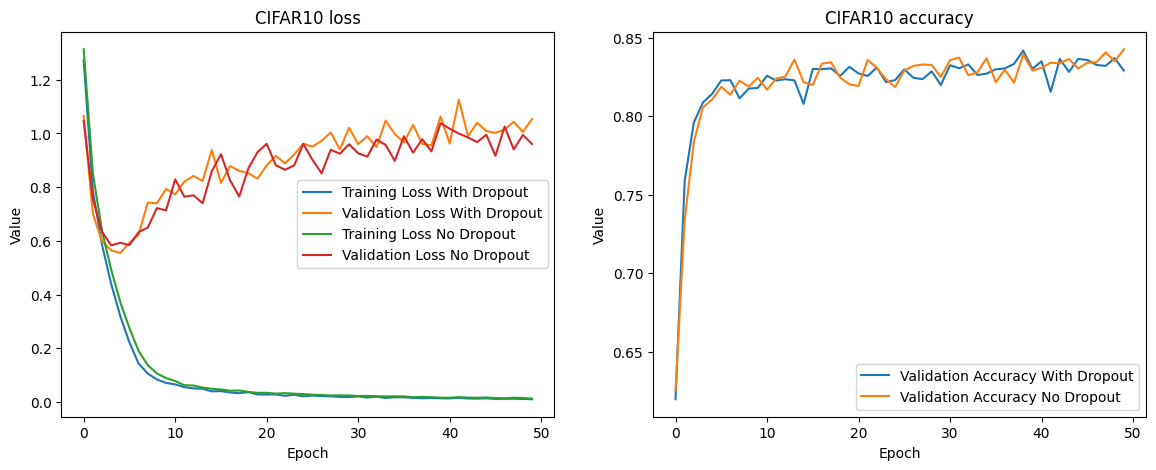

In [82]:
compare_two_models(train_losses_resnet11_cifar10, val_losses_resnet11_cifar10, val_accs_resnet11_cifar10, train_losses_resnet11_cifar10_no_dropout, val_losses_resnet11_cifar10_no_dropout, val_accs_resnet11_cifar10_no_dropout, "CIFAR10", "With Dropout", "No Dropout")

Epoch 1: Train Loss = 4.022009621495786, Val Loss = 3.655089361667633, Val Acc = 0.1236
Epoch 2: Train Loss = 3.53262503494692, Val Loss = 3.8972019863128664, Val Acc = 0.1293
Epoch 3: Train Loss = 3.193885684928016, Val Loss = 3.0488007259368897, Val Acc = 0.2237
Epoch 4: Train Loss = 2.9484030773572605, Val Loss = 2.77520432472229, Val Acc = 0.2838
Epoch 5: Train Loss = 2.7426558425054526, Val Loss = 2.5996660351753236, Val Acc = 0.3179
Epoch 6: Train Loss = 2.575776878830112, Val Loss = 2.4052662122249604, Val Acc = 0.3572
Epoch 7: Train Loss = 2.41543511539469, Val Loss = 2.3575233960151674, Val Acc = 0.3759
Epoch 8: Train Loss = 2.2642642338867383, Val Loss = 2.175324194431305, Val Acc = 0.4138
Epoch 9: Train Loss = 2.141042233428077, Val Loss = 1.9733478212356568, Val Acc = 0.4596
Epoch 10: Train Loss = 2.0123341202431018, Val Loss = 1.9264882040023803, Val Acc = 0.4627
Epoch 11: Train Loss = 1.9052172179722116, Val Loss = 1.9102937912940978, Val Acc = 0.4791
Epoch 12: Train Loss

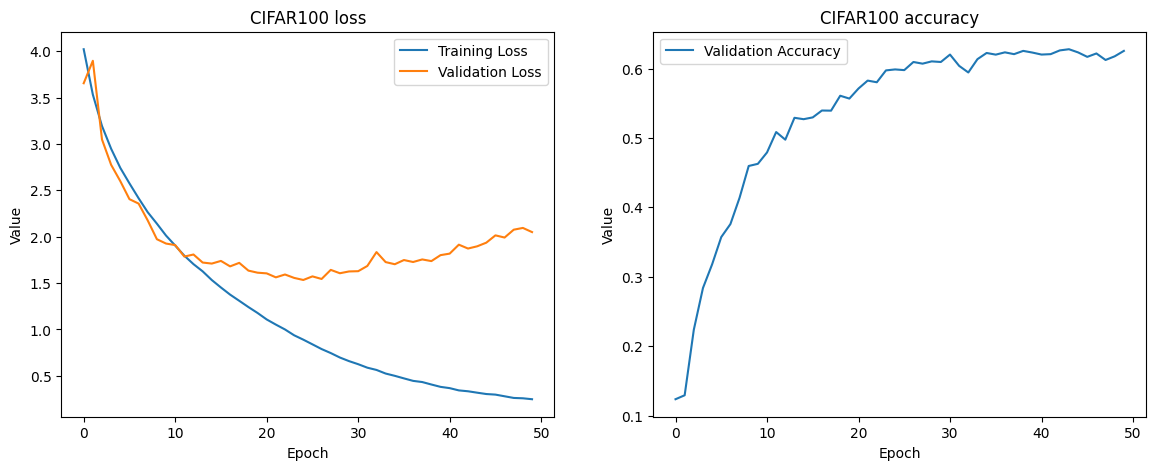

In [83]:
resnet11_cifar100 = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=100)
train_losses_resnet11_cifar100, val_losses_resnet11_cifar100, val_accs_resnet11_cifar100 = train_model(resnet11_cifar100, trainloader100, testloader100, epochs=50)
plot_losses_accs(train_losses_resnet11_cifar100, val_losses_resnet11_cifar100, val_accs_resnet11_cifar100, "CIFAR100")

Epoch 1: Train Loss = 3.791021606196528, Val Loss = 3.970184645652771, Val Acc = 0.0969
Epoch 2: Train Loss = 3.124943866754127, Val Loss = 3.0456088185310364, Val Acc = 0.2357
Epoch 3: Train Loss = 2.7210291529555457, Val Loss = 2.7905213236808777, Val Acc = 0.2822
Epoch 4: Train Loss = 2.4198799218668046, Val Loss = 2.636700842380524, Val Acc = 0.3245
Epoch 5: Train Loss = 2.191859084626903, Val Loss = 2.339709349870682, Val Acc = 0.3823
Epoch 6: Train Loss = 1.9860835499165919, Val Loss = 2.432892026901245, Val Acc = 0.3790
Epoch 7: Train Loss = 1.8261017186562423, Val Loss = 2.406722490787506, Val Acc = 0.3939
Epoch 8: Train Loss = 1.6698503232063235, Val Loss = 1.984828314781189, Val Acc = 0.4642
Epoch 9: Train Loss = 1.539866827028182, Val Loss = 2.1272136640548704, Val Acc = 0.4522
Epoch 10: Train Loss = 1.43058990944377, Val Loss = 1.8674359667301177, Val Acc = 0.4974
Epoch 11: Train Loss = 1.3247416345664607, Val Loss = 1.6691162073612213, Val Acc = 0.5388
Epoch 12: Train Loss

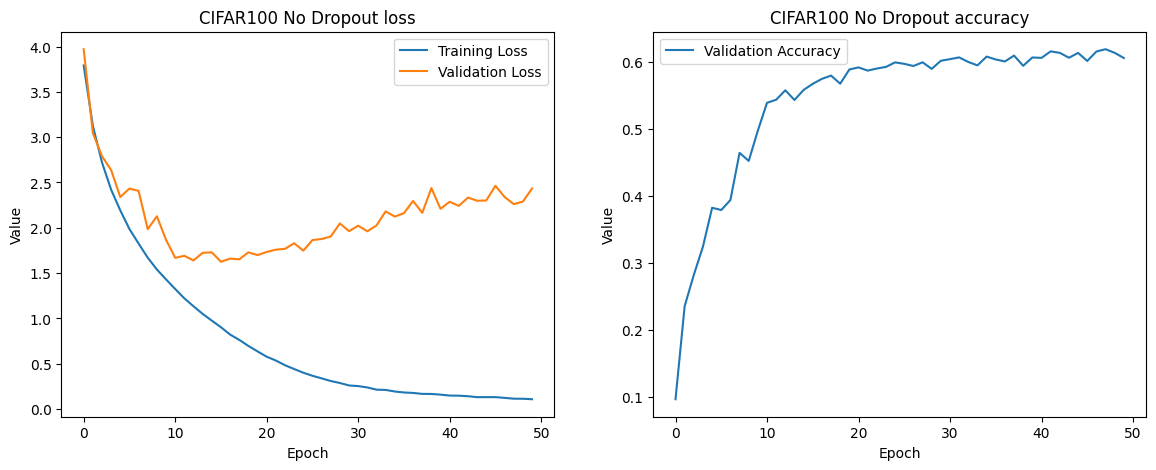

In [84]:
resnet11_cifar100_no_dropout = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=100, dropout=False)
train_losses_resnet11_cifar100_no_dropout, val_losses_resnet11_cifar100_no_dropout, val_accs_resnet11_cifar100_no_dropout = train_model(resnet11_cifar100_no_dropout, trainloader100, testloader100, epochs=50)
plot_losses_accs(train_losses_resnet11_cifar100_no_dropout, val_losses_resnet11_cifar100_no_dropout, val_accs_resnet11_cifar100_no_dropout, "CIFAR100 No Dropout")

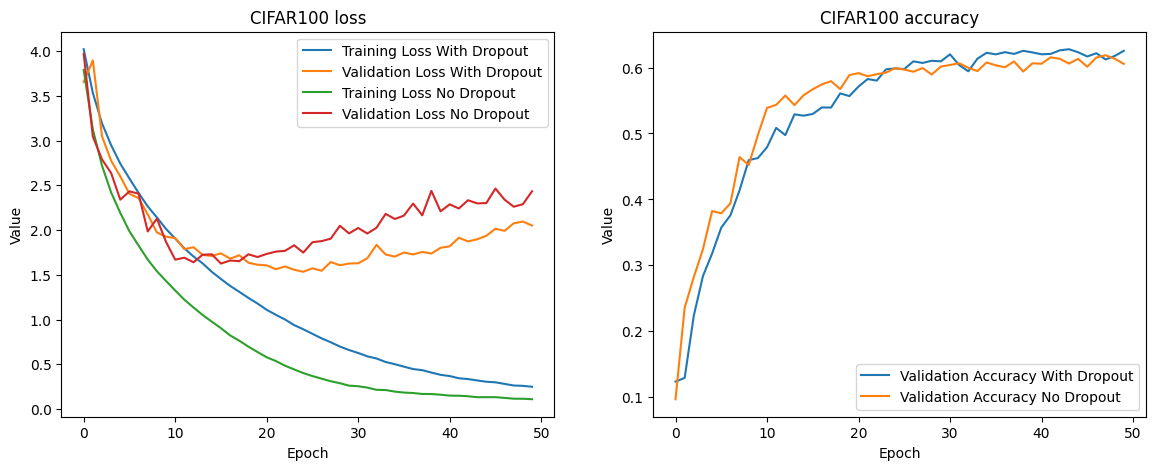

In [85]:
compare_two_models(train_losses_resnet11_cifar100, val_losses_resnet11_cifar100, val_accs_resnet11_cifar100, train_losses_resnet11_cifar100_no_dropout, val_losses_resnet11_cifar100_no_dropout, val_accs_resnet11_cifar100_no_dropout, "CIFAR100", "With Dropout", "No Dropout")

## resnet 18


In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet18(nn.Module):
    def __init__(self, block, num_classes=10, dropout=True):
        super(ResNet18, self).__init__()
        self.in_channels = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)


        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)


        self.fc = nn.Sequential(
            nn.Linear(512 * block.expansion, 256),
            nn.ReLU(),
            nn.Dropout() if dropout else nn.Identity(),
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


Epoch 1: Train Loss = 1.5724673472149435, Val Loss = 1.1706762911793522, Val Acc = 0.5696
Epoch 2: Train Loss = 1.1500297155200252, Val Loss = 0.9732175787416891, Val Acc = 0.6453
Epoch 3: Train Loss = 0.9348974733000296, Val Loss = 0.7634531715617012, Val Acc = 0.7298
Epoch 4: Train Loss = 0.7725851446943106, Val Loss = 0.6796692916855644, Val Acc = 0.7699
Epoch 5: Train Loss = 0.6418490577072039, Val Loss = 0.6266443626092265, Val Acc = 0.7901
Epoch 6: Train Loss = 0.5309913705174006, Val Loss = 0.6365965981357775, Val Acc = 0.7932
Epoch 7: Train Loss = 0.4367263422217113, Val Loss = 0.5696810555343811, Val Acc = 0.8213
Epoch 8: Train Loss = 0.35897842800376967, Val Loss = 0.5502301457638558, Val Acc = 0.8303
Epoch 9: Train Loss = 0.29258568500069115, Val Loss = 0.5784696441488906, Val Acc = 0.8291
Epoch 10: Train Loss = 0.23306585673328611, Val Loss = 0.5902376163024872, Val Acc = 0.8327
Epoch 11: Train Loss = 0.1862817521213589, Val Loss = 0.6924365285200814, Val Acc = 0.8221
Epoch

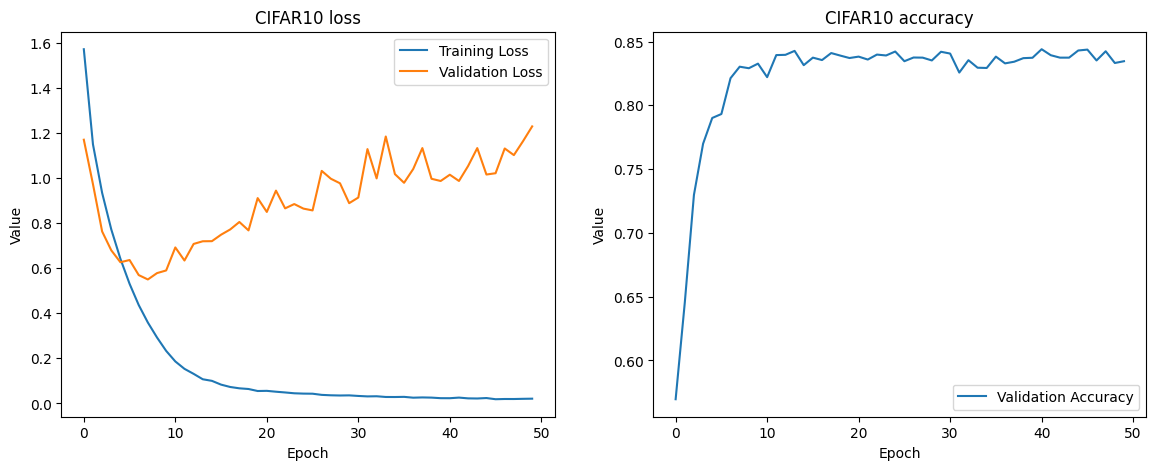

In [89]:
resnet_18_cifar10 = ResNet18(BasicBlock, num_classes=10)
train_losses_resnet_18_cifar10, val_losses_resnet_18_cifar10, val_accs_resnet_18_cifar10 = train_model(resnet_18_cifar10, trainloader, testloader, epochs=50)
plot_losses_accs(train_losses_resnet_18_cifar10, val_losses_resnet_18_cifar10, val_accs_resnet_18_cifar10, "CIFAR10")

Epoch 1: Train Loss = 1.425329813877894, Val Loss = 1.1302988462554762, Val Acc = 0.5924
Epoch 2: Train Loss = 0.9460095578634198, Val Loss = 0.7766729551382339, Val Acc = 0.7276
Epoch 3: Train Loss = 0.7039865295015996, Val Loss = 0.7124481665821502, Val Acc = 0.7508
Epoch 4: Train Loss = 0.5454714147329941, Val Loss = 0.5633316978859825, Val Acc = 0.8062
Epoch 5: Train Loss = 0.4399921209602042, Val Loss = 0.5123928458736347, Val Acc = 0.8284
Epoch 6: Train Loss = 0.34168084975396373, Val Loss = 0.5159895402935747, Val Acc = 0.8295
Epoch 7: Train Loss = 0.26088031371834947, Val Loss = 0.5234423931033466, Val Acc = 0.8370
Epoch 8: Train Loss = 0.1959143646665618, Val Loss = 0.6243411643436542, Val Acc = 0.8198
Epoch 9: Train Loss = 0.14462943181546878, Val Loss = 0.6255931337706198, Val Acc = 0.8355
Epoch 10: Train Loss = 0.11110477330142564, Val Loss = 0.6096287211313987, Val Acc = 0.8436
Epoch 11: Train Loss = 0.09200321661059042, Val Loss = 0.6618719288763909, Val Acc = 0.8338
Epoc

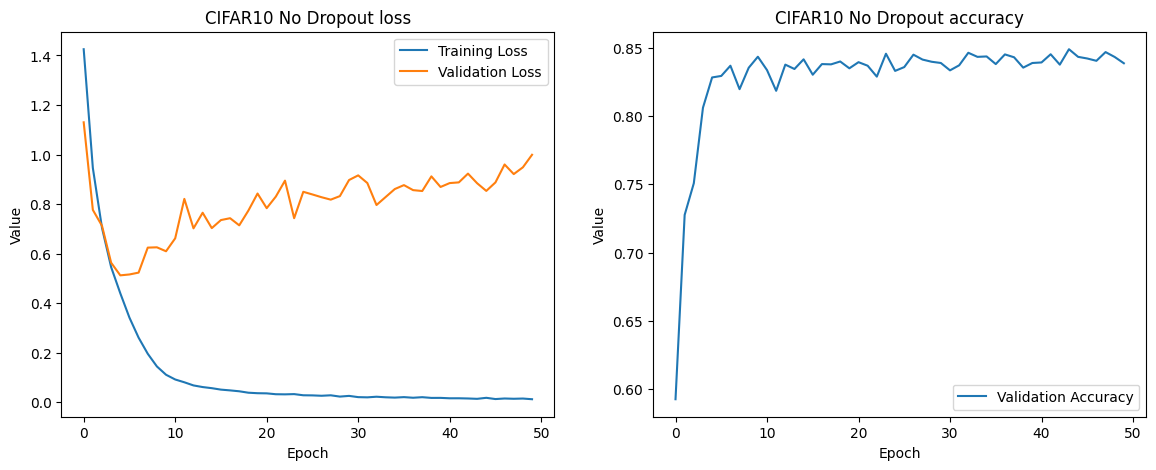

In [93]:
resnet_18_cifar10_no_dropout = ResNet18(BasicBlock, num_classes=10, dropout=False)
train_losses_resnet_18_cifar10_no_dropout, val_losses_resnet_18_cifar10_no_dropout, val_accs_resnet_18_cifar10_no_dropout = train_model(resnet_18_cifar10_no_dropout, trainloader, testloader, epochs=50)
plot_losses_accs(train_losses_resnet_18_cifar10_no_dropout, val_losses_resnet_18_cifar10_no_dropout, val_accs_resnet_18_cifar10_no_dropout, "CIFAR10 No Dropout")

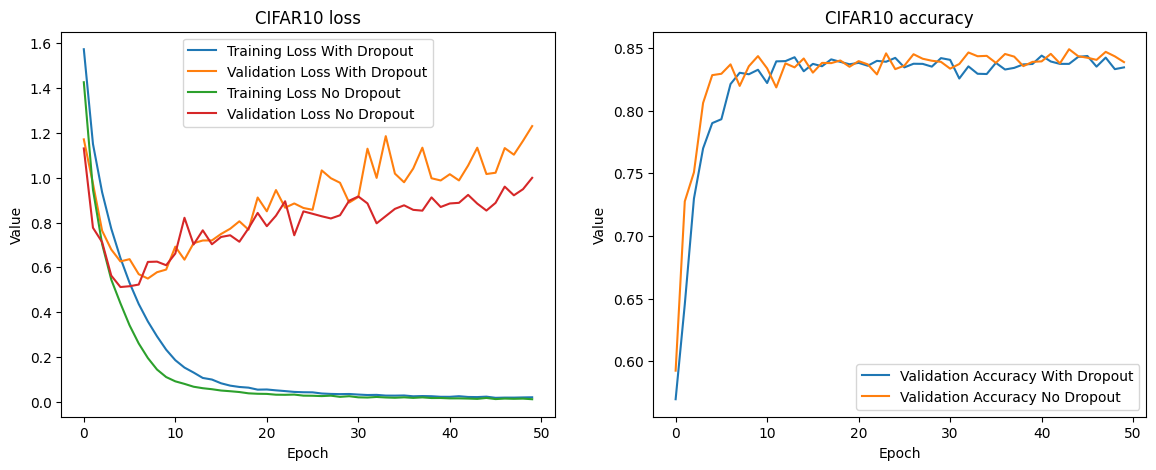

In [96]:
compare_two_models(train_losses_resnet_18_cifar10, val_losses_resnet_18_cifar10, val_accs_resnet_18_cifar10, train_losses_resnet_18_cifar10_no_dropout, val_losses_resnet_18_cifar10_no_dropout, val_accs_resnet_18_cifar10_no_dropout, "CIFAR10", "With Dropout", "No Dropout")

Epoch 1: Train Loss = 4.2013434540585175, Val Loss = 3.926476094722748, Val Acc = 0.0746
Epoch 2: Train Loss = 3.858849062029358, Val Loss = 3.692864441871643, Val Acc = 0.1199
Epoch 3: Train Loss = 3.611442182984803, Val Loss = 3.7864315581321715, Val Acc = 0.1218
Epoch 4: Train Loss = 3.3696146694290667, Val Loss = 3.378008394241333, Val Acc = 0.1700
Epoch 5: Train Loss = 3.1340082081992304, Val Loss = 3.2239122009277343, Val Acc = 0.2075
Epoch 6: Train Loss = 2.9482891279108383, Val Loss = 2.942505943775177, Val Acc = 0.2639
Epoch 7: Train Loss = 2.779465105222619, Val Loss = 2.6035366606712342, Val Acc = 0.3085
Epoch 8: Train Loss = 2.611538537627901, Val Loss = 2.6190357303619383, Val Acc = 0.3199
Epoch 9: Train Loss = 2.4749183191362856, Val Loss = 2.3902711868286133, Val Acc = 0.3679
Epoch 10: Train Loss = 2.3405833454693066, Val Loss = 2.376665246486664, Val Acc = 0.3751
Epoch 11: Train Loss = 2.2149672310065736, Val Loss = 2.090106598138809, Val Acc = 0.4296
Epoch 12: Train Lo

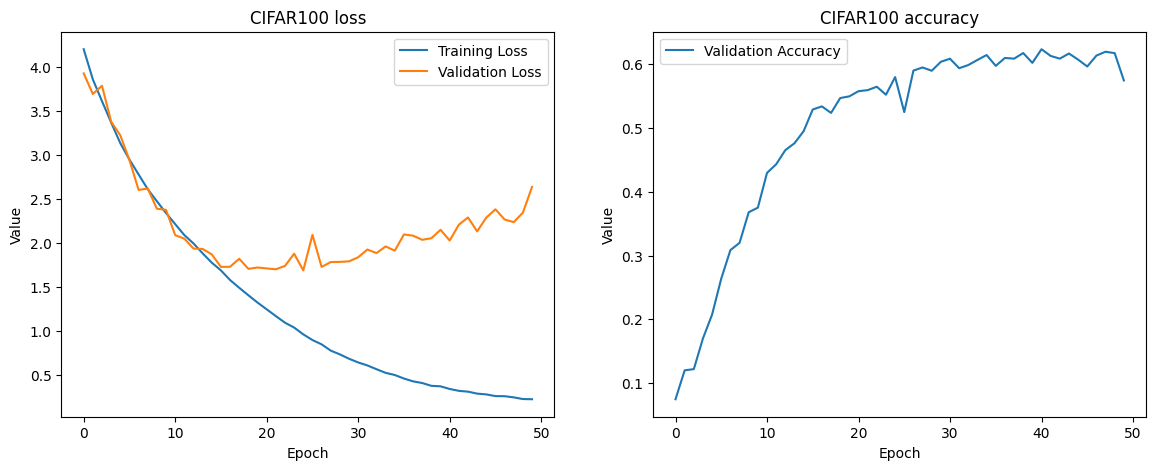

In [94]:
resnet_18_cifar100 = ResNet18(BasicBlock, num_classes=100)
train_losses_resnet_18_cifar100, val_losses_resnet_18_cifar100, val_accs_resnet_18_cifar100 = train_model(resnet_18_cifar100, trainloader100, testloader100, epochs=50)
plot_losses_accs(train_losses_resnet_18_cifar100, val_losses_resnet_18_cifar100, val_accs_resnet_18_cifar100, "CIFAR100")

Epoch 1: Train Loss = 3.937920717936952, Val Loss = 3.839783742427826, Val Acc = 0.0982
Epoch 2: Train Loss = 3.3876860971036167, Val Loss = 3.1859878587722776, Val Acc = 0.2123
Epoch 3: Train Loss = 2.906061792617564, Val Loss = 2.824834976196289, Val Acc = 0.2724
Epoch 4: Train Loss = 2.5573410609798968, Val Loss = 2.7003108716011046, Val Acc = 0.2991
Epoch 5: Train Loss = 2.3061286479310916, Val Loss = 2.5498068284988404, Val Acc = 0.3432
Epoch 6: Train Loss = 2.0985109924965197, Val Loss = 2.5411032533645628, Val Acc = 0.3571
Epoch 7: Train Loss = 1.9164839467734023, Val Loss = 2.4861650359630585, Val Acc = 0.3745
Epoch 8: Train Loss = 1.7536233328187558, Val Loss = 2.4667505717277525, Val Acc = 0.3865
Epoch 9: Train Loss = 1.620621680908496, Val Loss = 2.0044221723079683, Val Acc = 0.4713
Epoch 10: Train Loss = 1.4961583452761327, Val Loss = 1.7831028532981872, Val Acc = 0.5172
Epoch 11: Train Loss = 1.3711182778448705, Val Loss = 1.686472351551056, Val Acc = 0.5419
Epoch 12: Trai

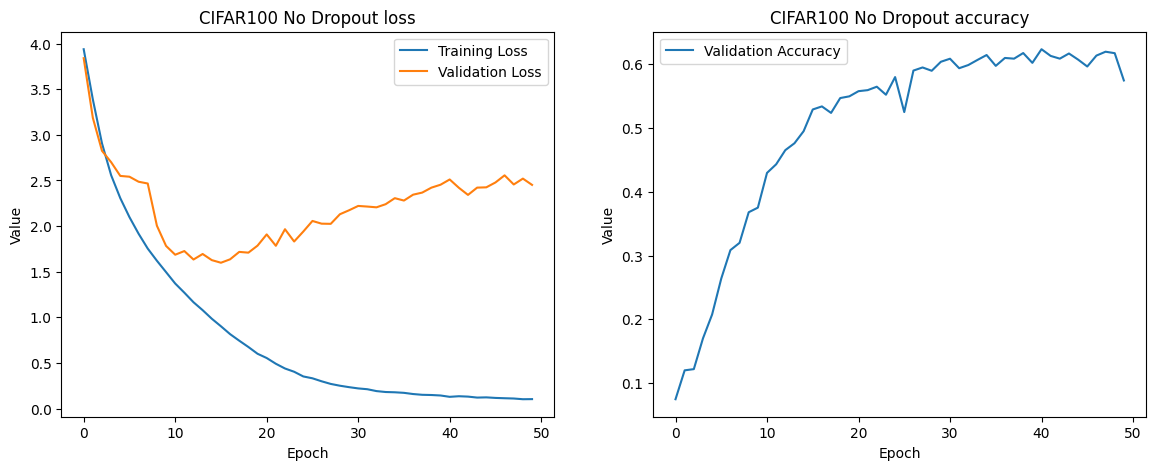

In [95]:
resnet_18_cifar100_no_dropout = ResNet18(BasicBlock, num_classes=100, dropout=False)
train_losses_resnet_18_cifar100_no_dropout, val_losses_resnet_18_cifar100_no_dropout, val_accs_resnet_18_cifar100_no_dropout = train_model(resnet_18_cifar100_no_dropout, trainloader100, testloader100, epochs=50)
plot_losses_accs(train_losses_resnet_18_cifar100_no_dropout, val_losses_resnet_18_cifar100_no_dropout, val_accs_resnet_18_cifar100, "CIFAR100 No Dropout")

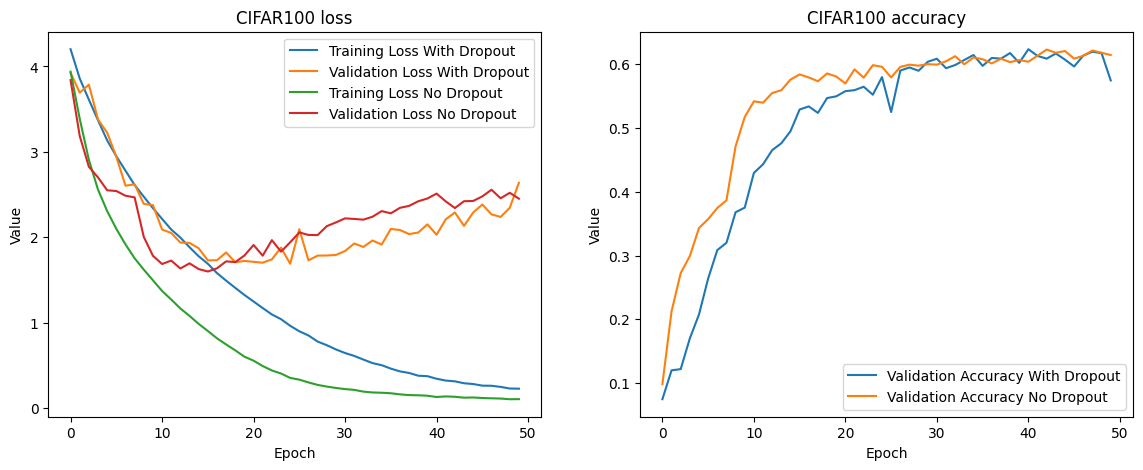

In [97]:
compare_two_models(train_losses_resnet_18_cifar100, val_losses_resnet_18_cifar100, val_accs_resnet_18_cifar100, train_losses_resnet_18_cifar100_no_dropout, val_losses_resnet_18_cifar100_no_dropout, val_accs_resnet_18_cifar100_no_dropout, "CIFAR100", "With Dropout", "No Dropout")